In [54]:
import numpy as np
import pandas as pd
import string
import re
import os

# Plotting:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# Import the seaborn palette, change for different applications.
from palettable.tableau import PurpleGray_6 as palette

sns.set_palette(palette.mpl_colors) #Set the seaborn palette
palette = palette.mpl_colors #Store the seaborn palette

# Plot output:
from matplotlib.backends.backend_pdf import PdfPages
import os

def readplatemap(platemap: str, levelnames: list = ['column', 'row', 'Well']) -> pd.DataFrame:
    ''' Reads in an Excel platemap to a dataframe.
    Parameters:
        platemap: path to .xlsx file with the platemap
        levelnames: list of the different levels in the platemap (seperated by commas)
    Return:
        DataFrame: dataframe of the annotated levelnames and the wells they belong to.
    '''
    log = "platemap read from: " + platemap
    platemap = pd.read_excel(platemap, sheetname = 0, header = 1, index_col = 1) #If the platemap is a .xlsx sheet read it in using read_excel:
    platemap = platemap.loc[platemap.index.isin(list(string.ascii_letters)), platemap.columns.isin(range(0,25))] #Remove any columns or rows that aren't named by integer or letter respectively:
    platemap.index.name = 'row' #Name the platemap index
    platemap = pd.melt(platemap.reset_index(col_fill = ['row']), id_vars='row', var_name='column') #Reshape the platemap into a long form
    platemap['Well'] = platemap['row'] + platemap['column'].astype(str) #concatonate to get the row column
    annotation = platemap['value'].str.split(pat = ',', expand = True) #split the annotations on commas to produce different levels
    annotation.columns = levelnames[:-1] #ignore the well column
    platemap = pd.concat([platemap, annotation], axis = 1).drop('value', axis = 1) #join the annotations with the wells again and remove the old value variable
    platemap = platemap.replace('NA', np.nan)
    platemap['Well'] = platemap['Well'].map(lambda x: x if len(x) == 3 else x[0]+'0'+x[1])
    return(platemap)

def parse_raw(xlsx: str, platemap:pd.DataFrame, sheetname:str ='Raw', levelnames:list=['row','column','Well']) -> pd.DataFrame:
    ''' Reads in the plate data from an Excel sheet, annotates it with data from a platemap and transfers timestamps to hours'''
    # read in file:
    plate = pd.read_excel(xlsx, sheetname=sheetname)
    log = "Data read from " + xlsx + ', ' + sheetname + '.'
    print(log)
    plate = platemap.merge(plate)
    plate['measurement_step'] = plate['Tick'] % 12
    
    hours = plate['TimeStamp'].str.split(':', expand=True)
    hours.columns = ['hours', 'minutes', 'seconds']
    hours['year'] = '2018'
    hours['day'] = '1'
    hours['month'] = '1'
    hours = pd.to_datetime(hours)
    hours = hours-hours[0]
    hours = hours.dt.total_seconds()/60/60
    plate['Time (hrs)'] = hours
    return(plate)

def parse_rate(xlsx: str, platemap:pd.DataFrame, sheetname:str ='Rate', levelnames:list=['row','column','Well']) -> pd.DataFrame:
    ''' Reads in the plate data from an Excel sheet, annotates it with data from a platemap and transfers timestamps to hours'''
    # read in file:
    plate = pd.read_excel(xlsx, sheetname=sheetname)
    log = "Data read from " + xlsx + ', ' + sheetname + '.'
    print(log)
    plate = platemap.merge(plate)
    hours = (plate['Time']-plate['Time'].iloc[0])/60
    plate['Time (hrs)'] = hours
    return(plate)


def plot_variable(data, condition='strain', value = 'pH', correct=True):
    pdf = PdfPages('test.pdf')
    if correct:
        try:
            data = data.query('measurement_step == 0')
        except:
            print('Data is either a rate, or the raw data measurement step was not parsed correctly.')
    # plot with hues
    sns.tsplot(data = data, condition = condition, unit = 'Well', time = 'Time (hrs)', value = value, err_style='unit_traces')
    plt.suptitle(condition)
    plt.show()

    # plot seperately
    for name,sub in data.groupby(by = ['strain']):
        fig, ax = plt.subplots()
        ax = sns.tsplot(ax = ax, data = sub, condition = condition, unit = 'Well', time = 'Time (hrs)', value = value, err_style='unit_traces')
        # ax2 =ax.twinx()
        # sns.tsplot(data = sub, condition = condition, unit = 'Well', time = 'Time (hrs)', value = 'pH')
        plt.suptitle(name)
        pdf.savefig()
        plt.show()
    pdf.close()
    return()

def parse_plate(xlsx:str, platemap:str, levelnames:list = ['row','column','Well']):
    print('Reading data from {platemap}.'.format(platemap=platemap))
    platemap = readplatemap(platemap=platemap, levelnames=levelnames)
    print('Complete')
    rate = parse_rate(xlsx=xlsx, platemap=platemap, levelnames=levelnames)
    print('Complete')
    raw = parse_raw(xlsx=xlsx, platemap=platemap, levelnames=levelnames)
    print('Complete')
    return(raw,rate)

# how to get derivatives
# plate['pH_diff'] = plate.groupby('Well')['pH'].diff().diff()

In [55]:


# attempt at user input
xlsx = input(prompt='Path to data .xlsx:')
platemap = input(prompt='Path to platemap .xlsx:')


xlsx = '2018 03 29 replicate 02 09 assay KS.xlsx'
platemap = 'platemap.xlsx'
levelnames = ['strain','Well']

raw,rate = parse_plate(xlsx = '2018 03 29 replicate 02 09 assay KS.xlsx',platemap = 'platemap.xlsx', levelnames = ['strain','Well'])

plot_variable(rate, condition='strain', value='OCR')

Path to data .xlsx:
Path to platemap .xlsx:
Reading data from platemap.xlsx.
Complete
Data read from 2018 03 29 replicate 02 09 assay KS.xlsx, Rate.
Complete
Data read from 2018 03 29 replicate 02 09 assay KS.xlsx, Raw.
Complete


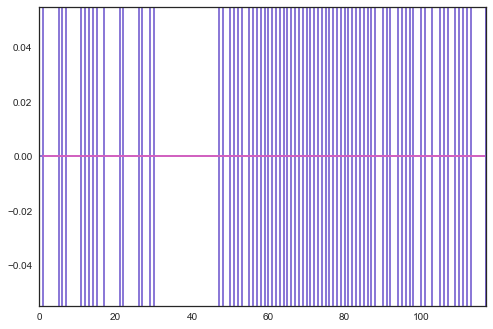

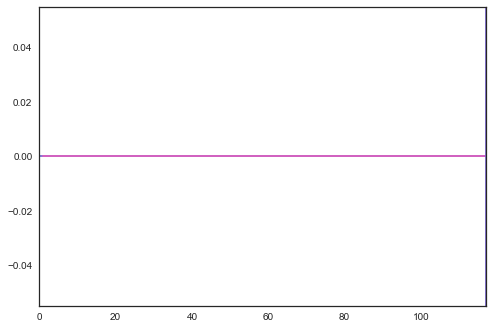

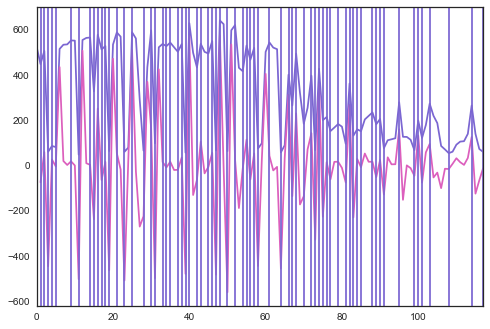

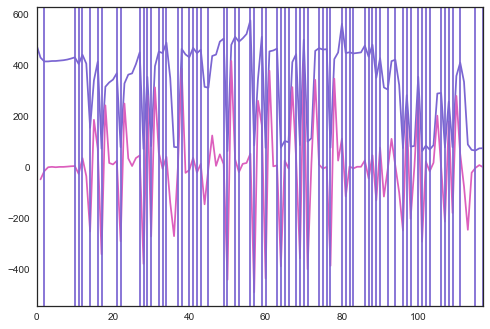

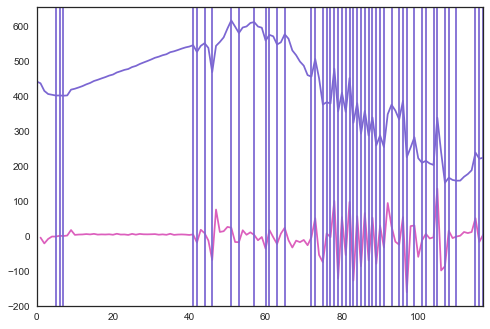

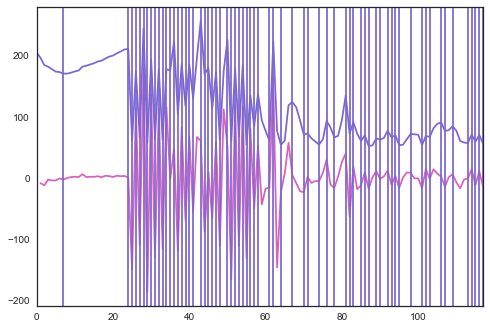

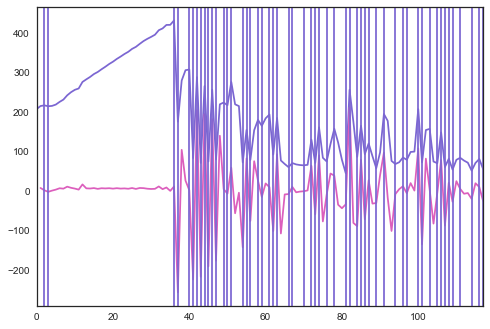

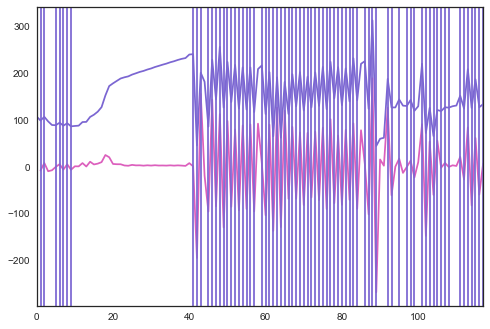

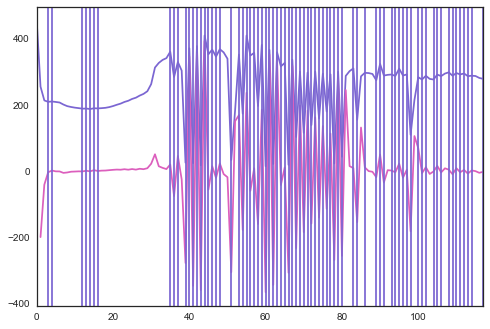

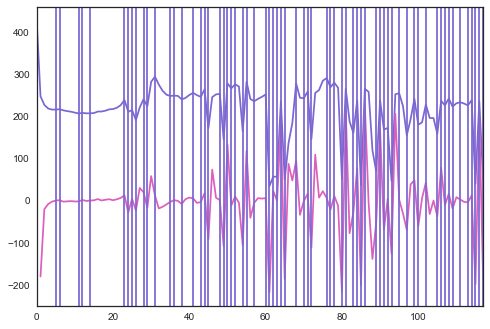

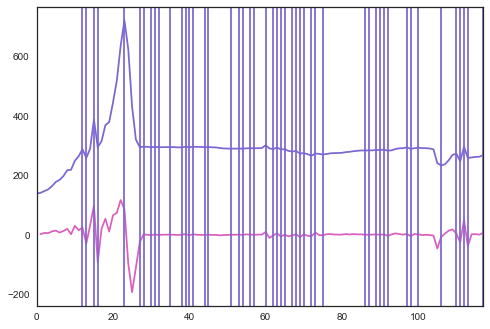

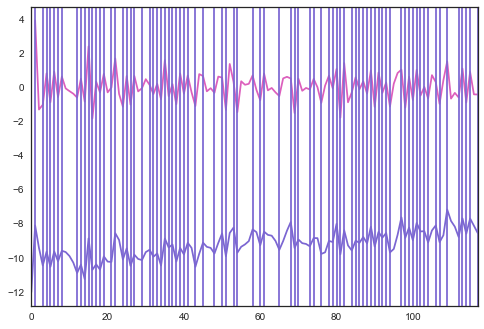

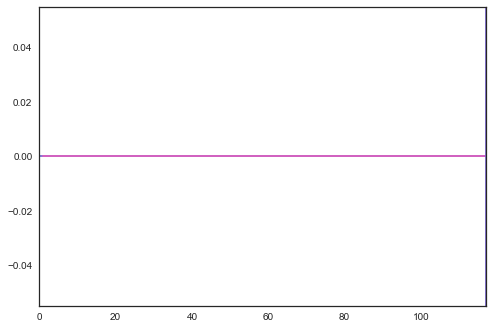

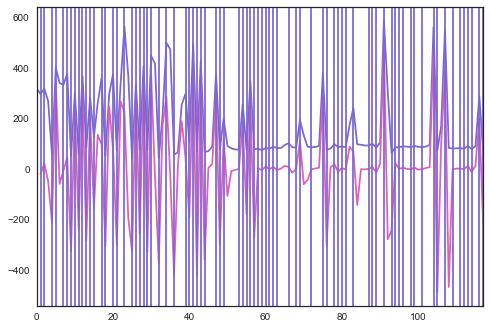

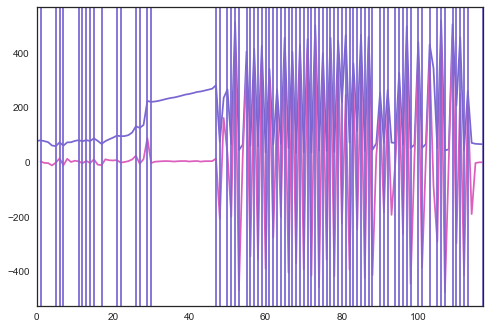

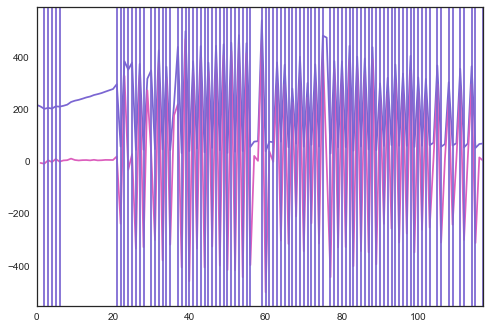

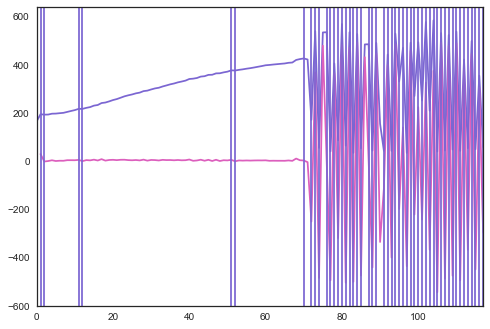

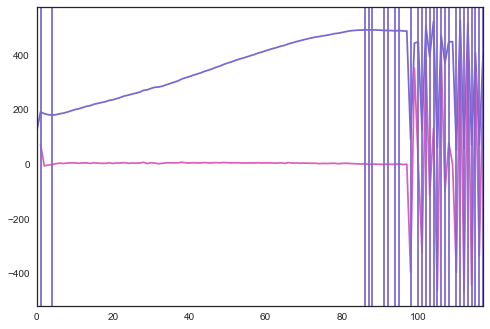

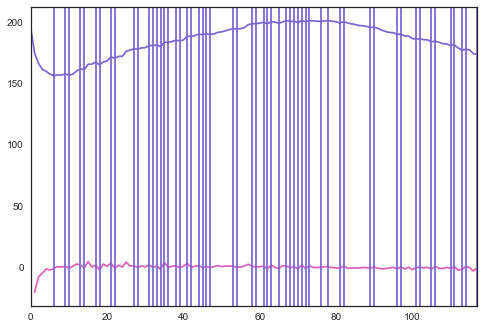

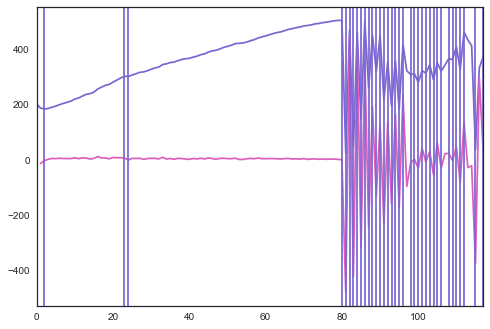

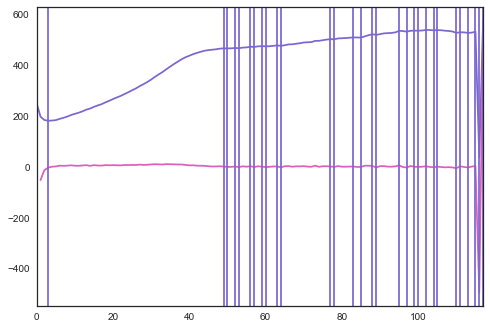

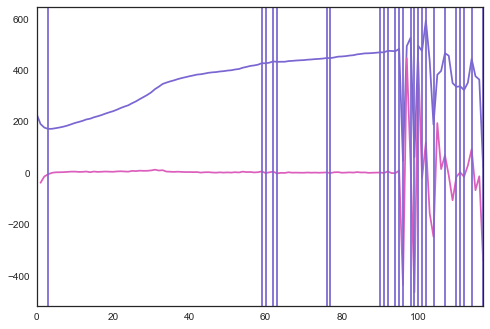

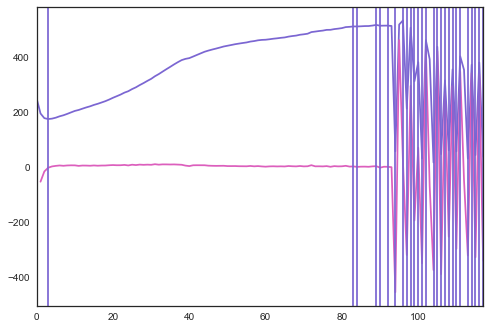

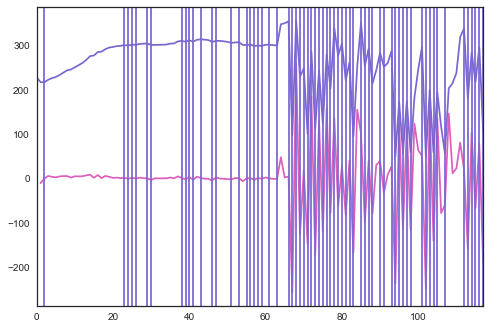

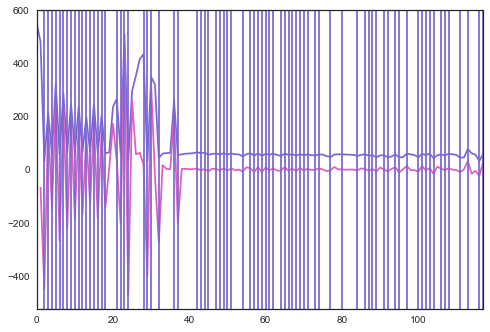

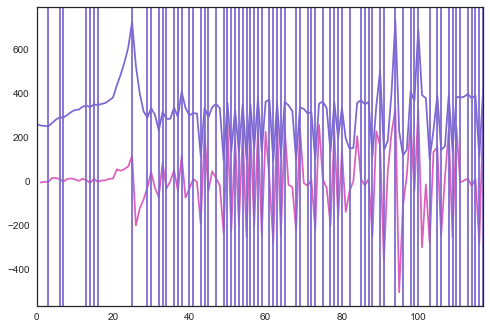

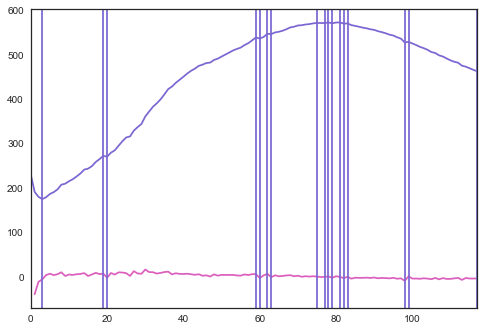

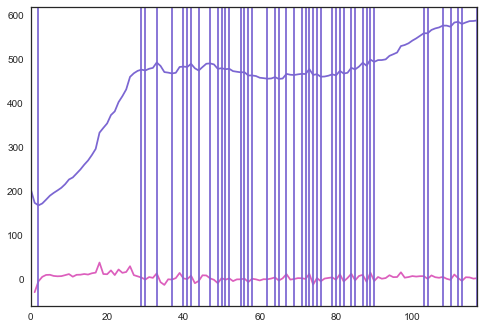

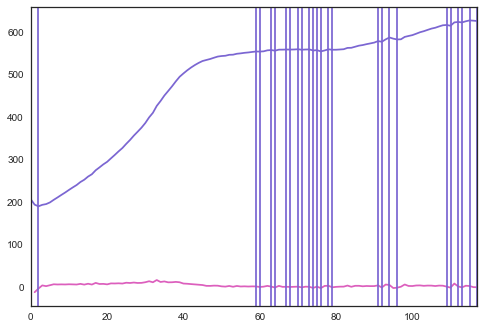

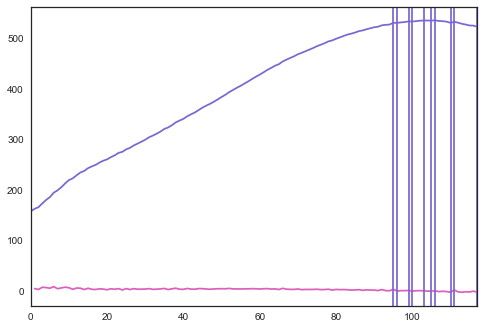

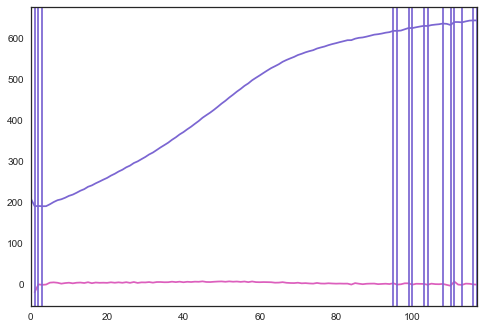

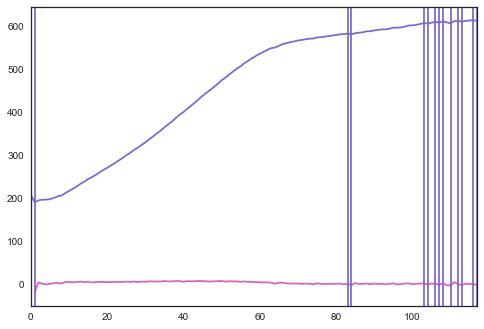

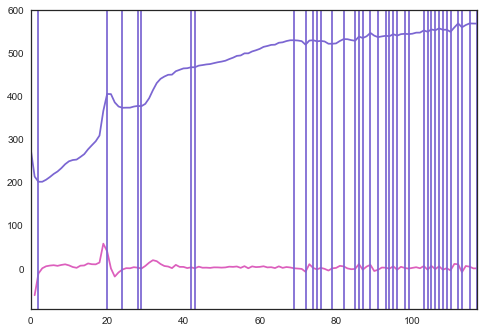

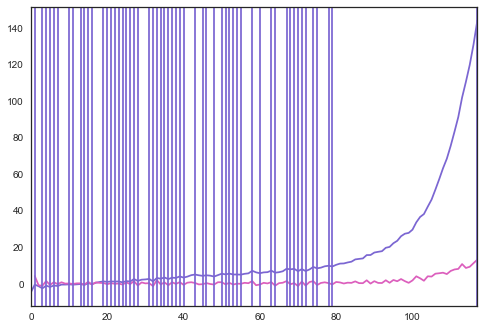

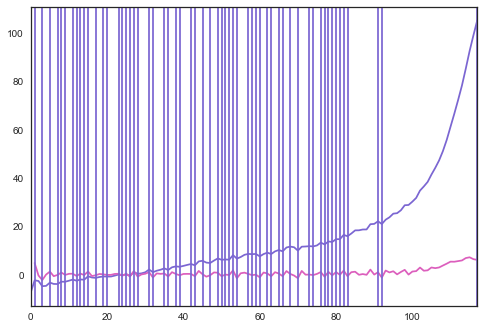

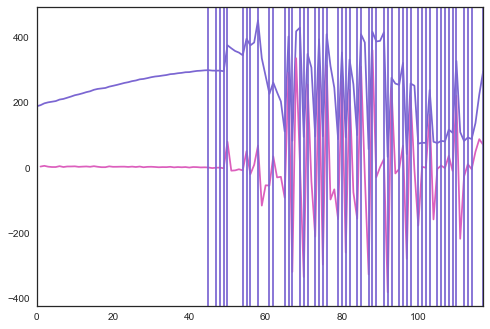

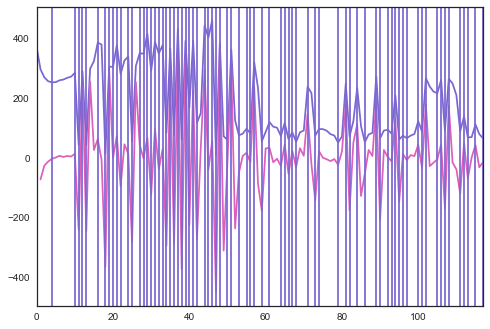

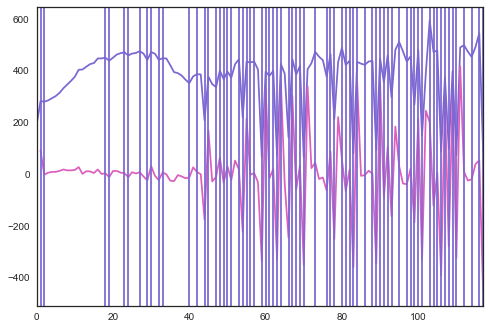

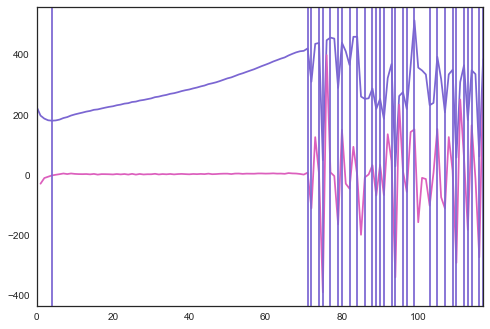

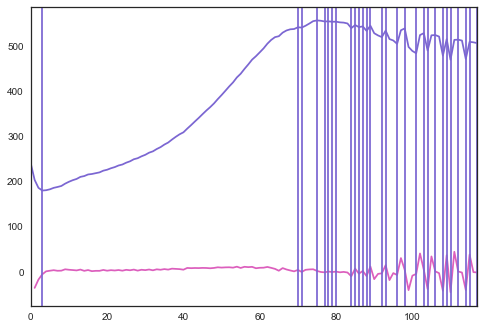

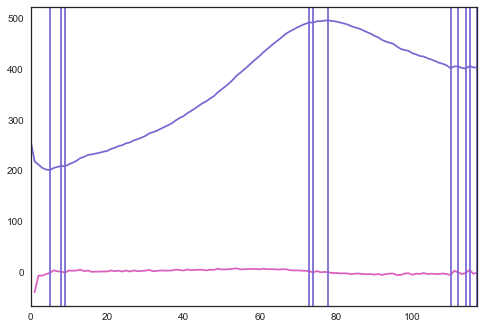

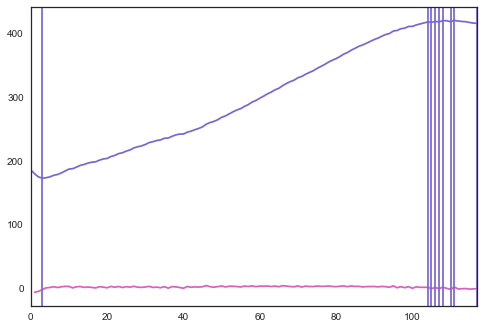

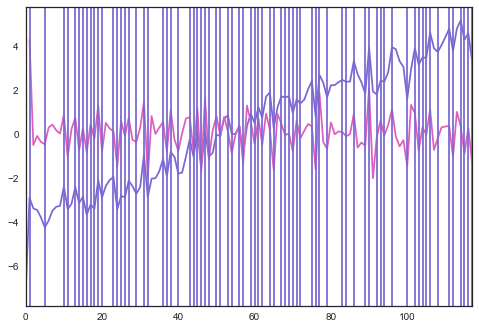

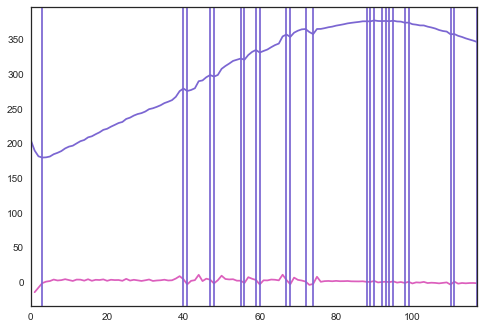

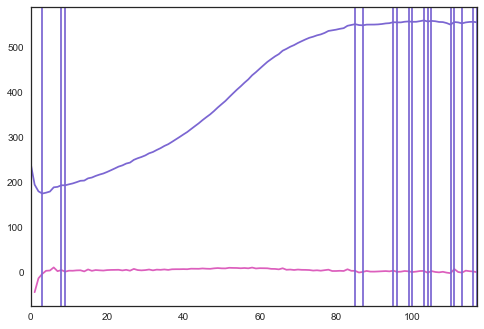

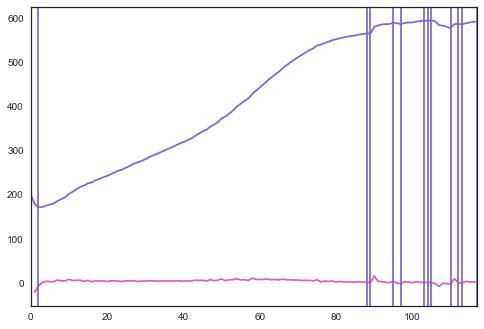

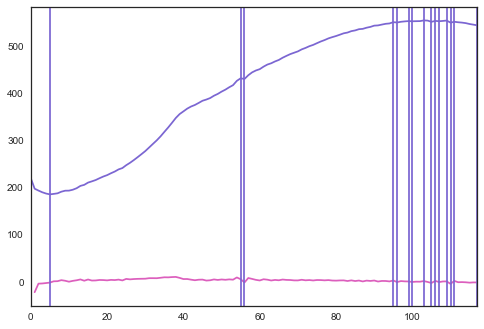

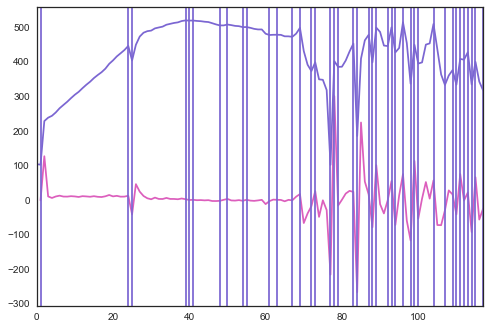

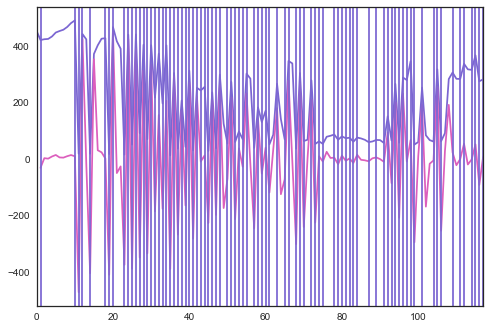

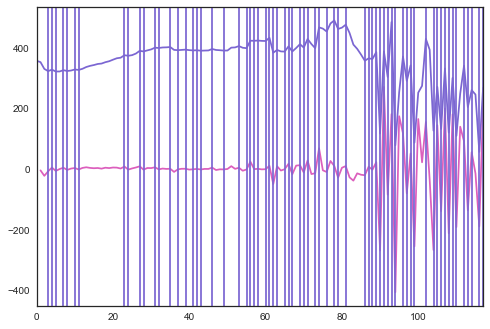

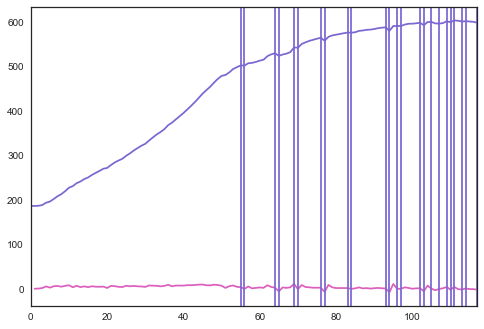

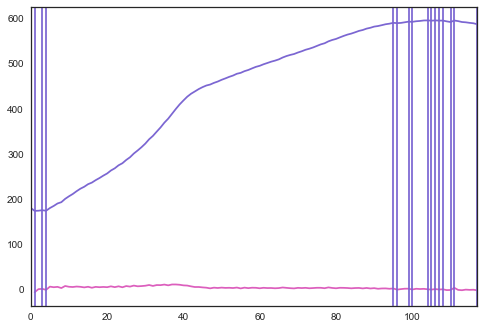

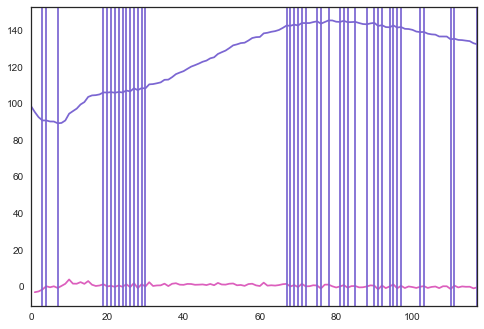

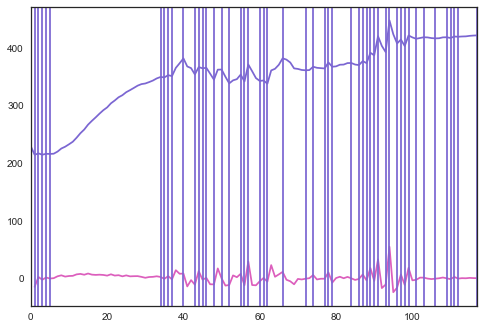

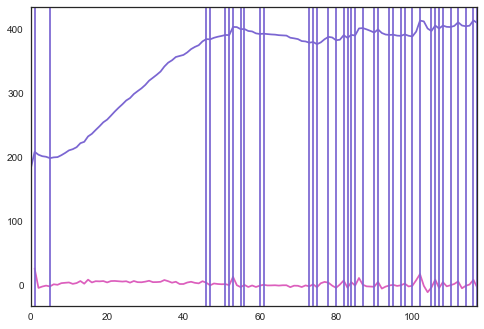

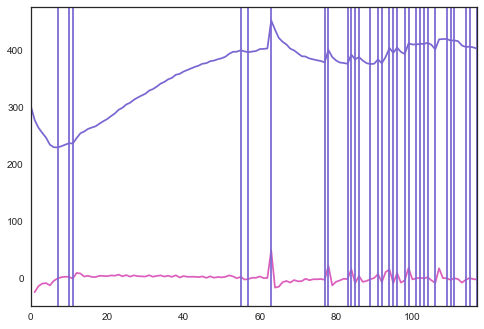

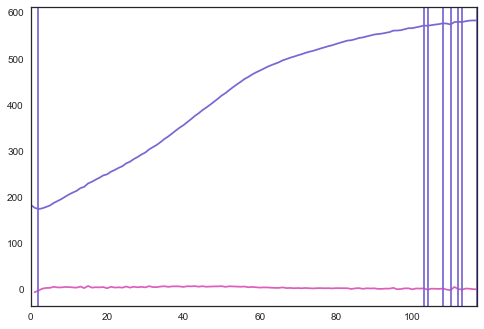

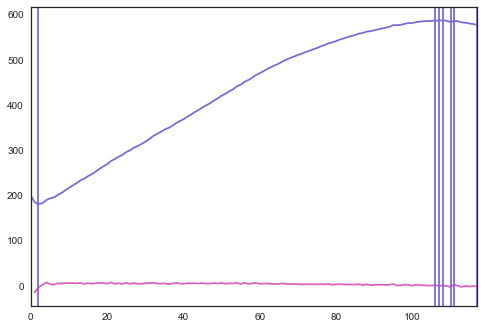

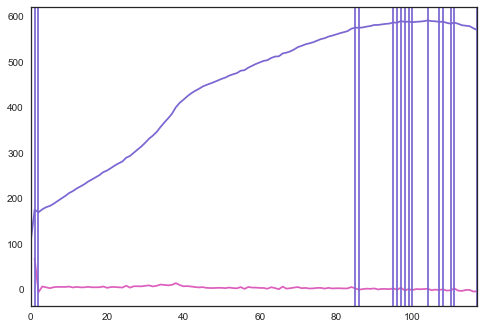

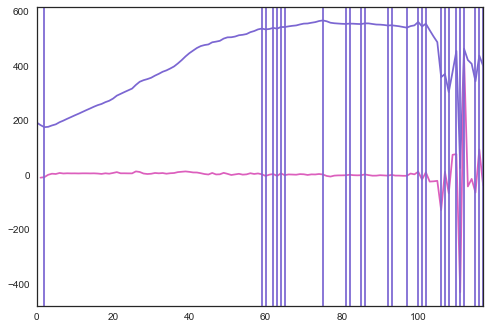

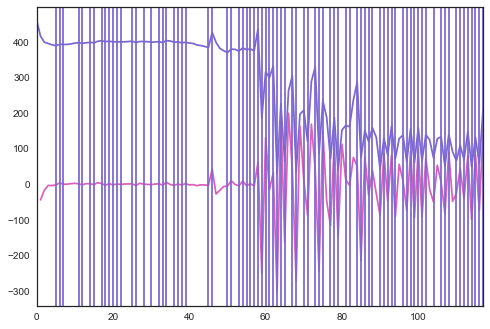

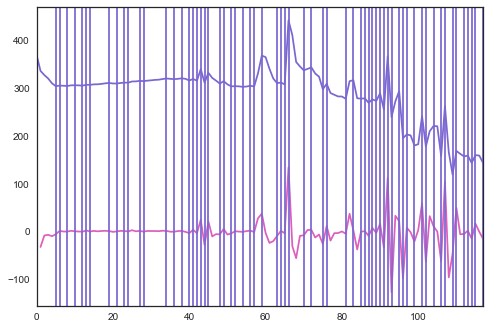

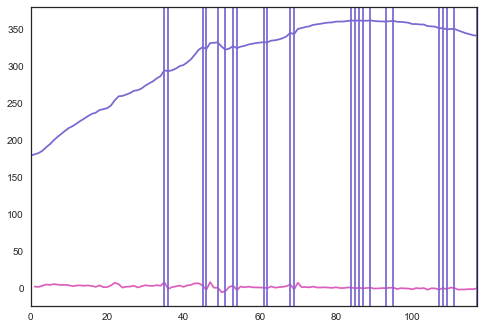

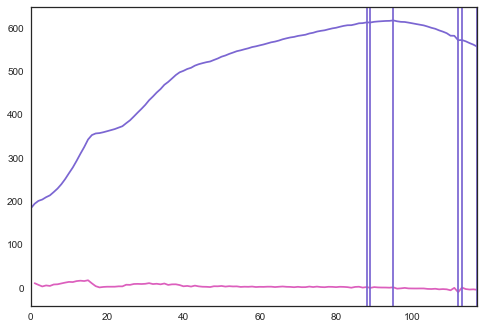

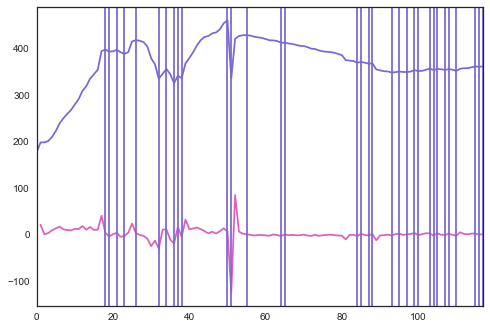

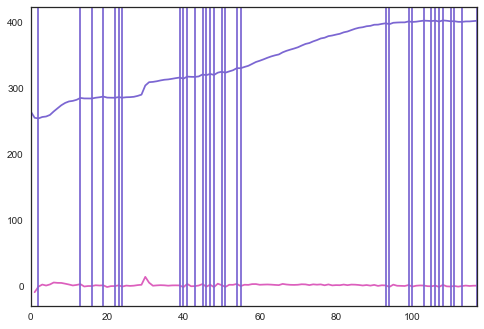

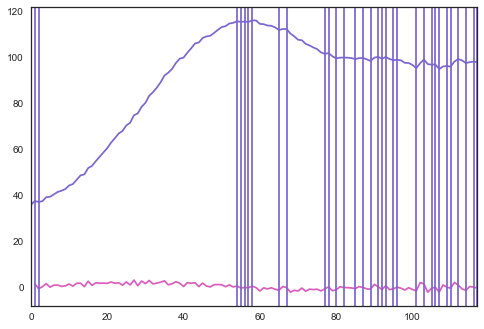

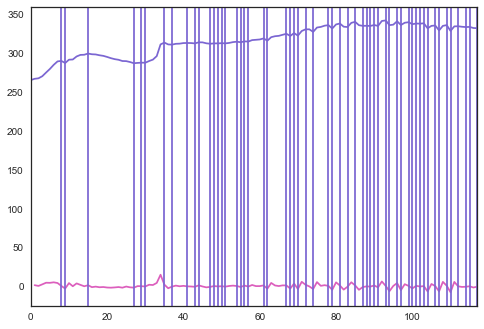

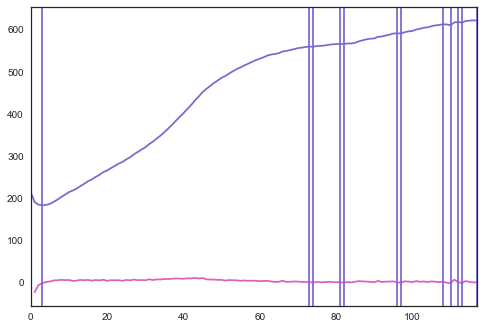

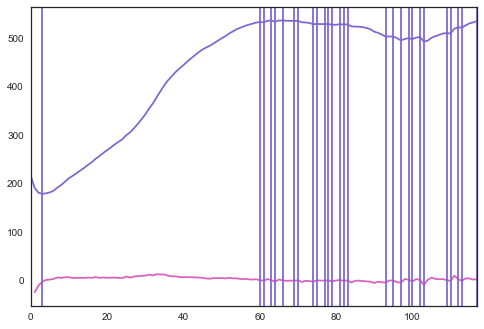

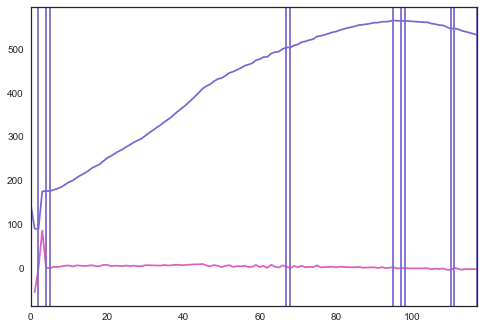

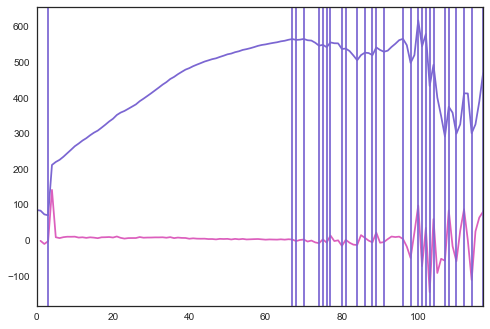

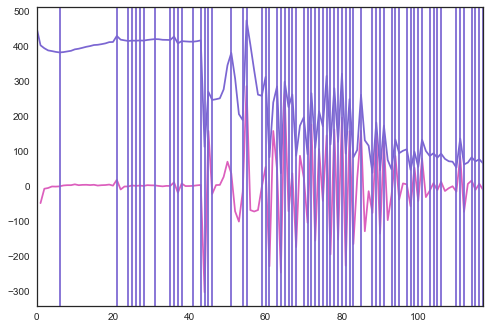

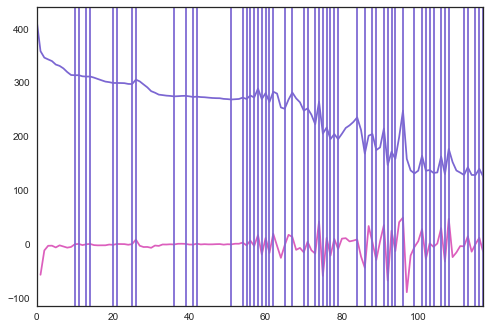

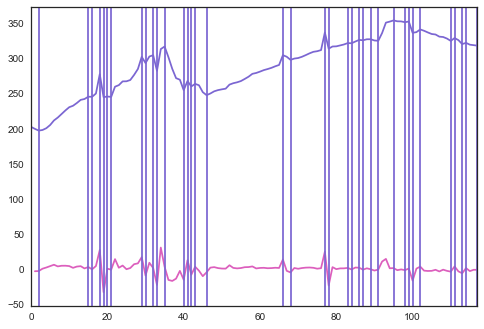

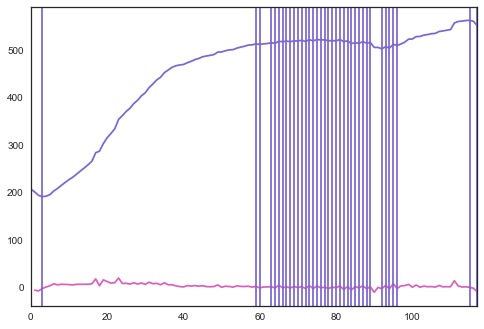

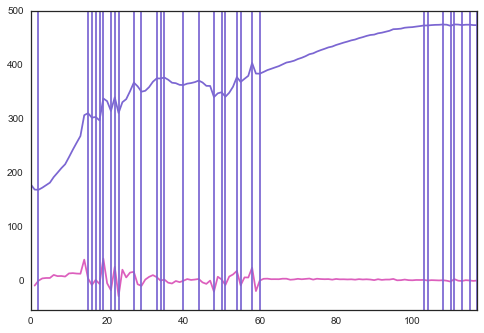

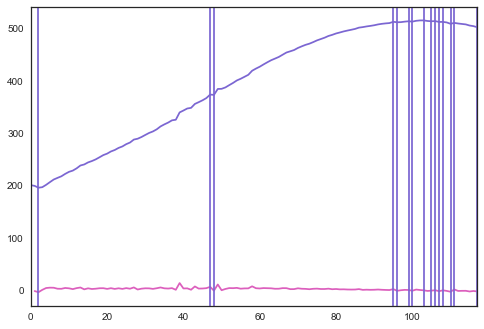

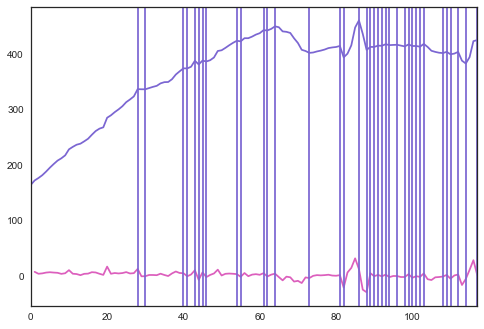

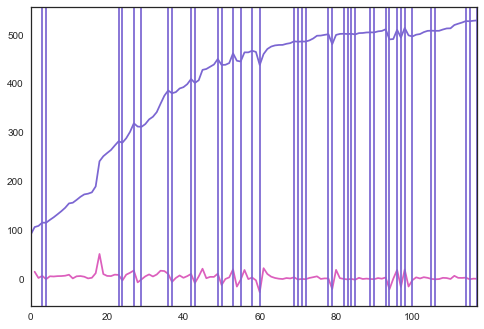

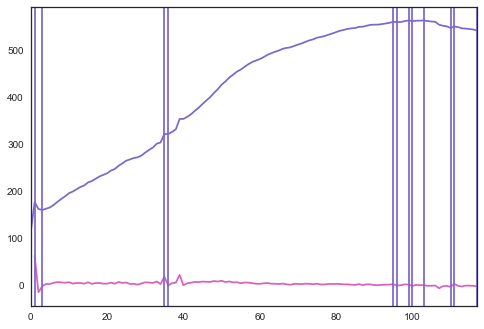

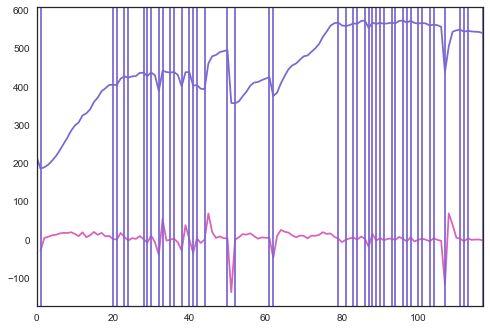

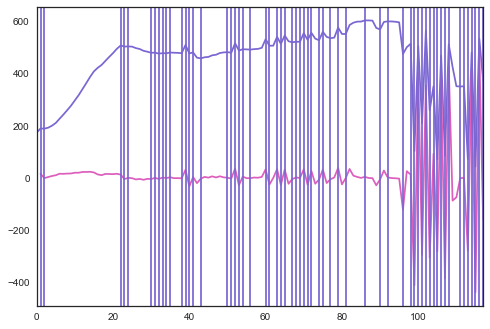

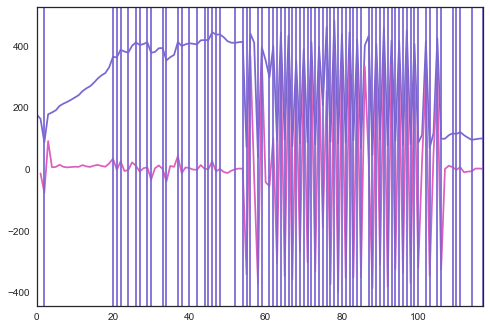

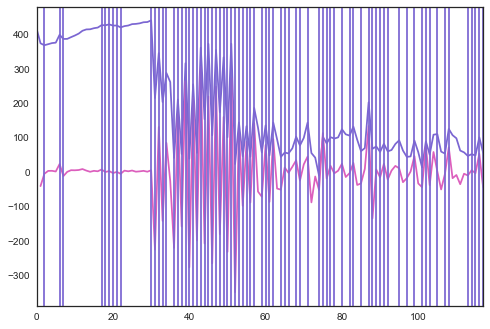

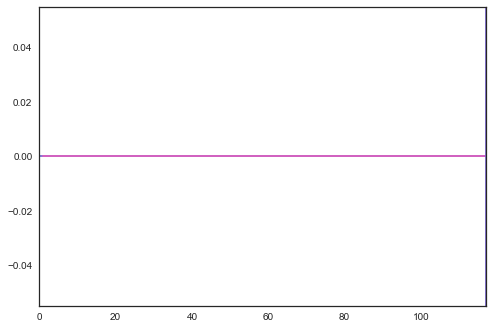

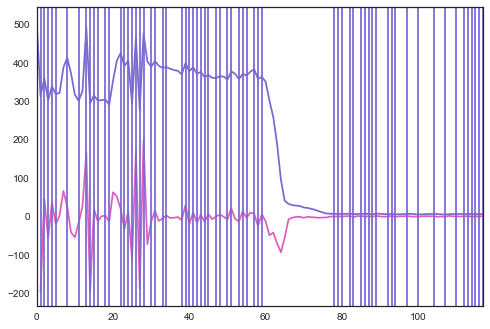

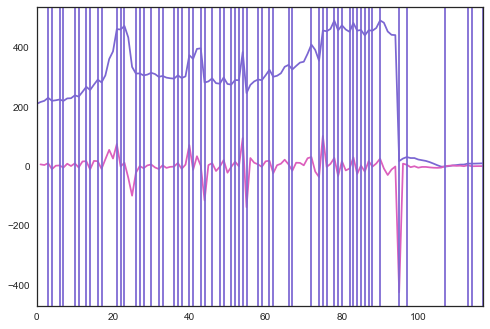

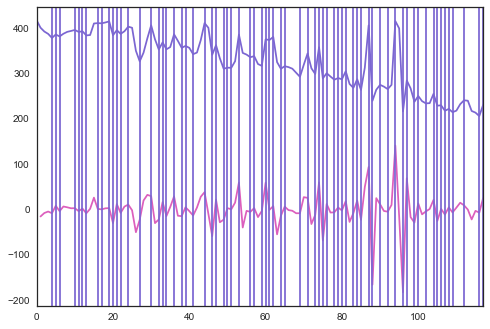

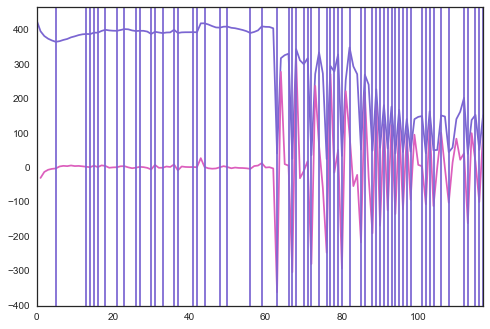

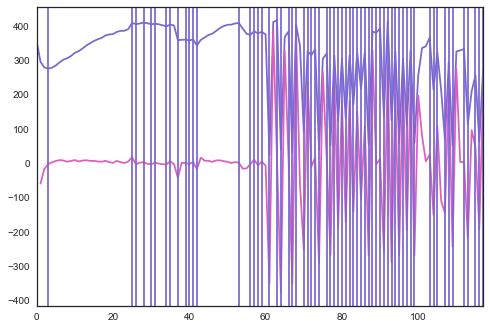

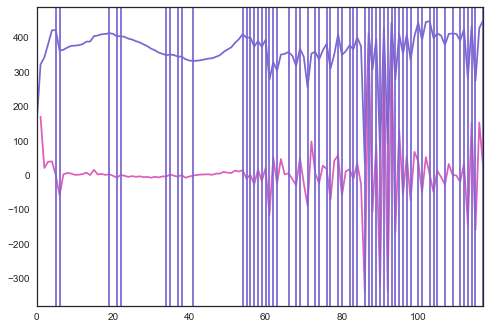

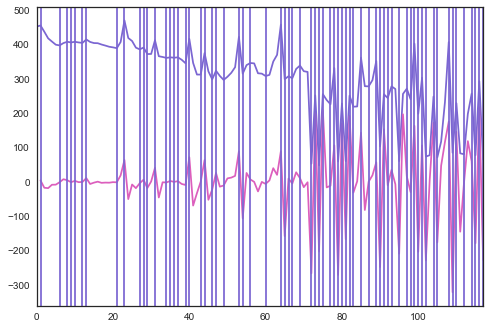

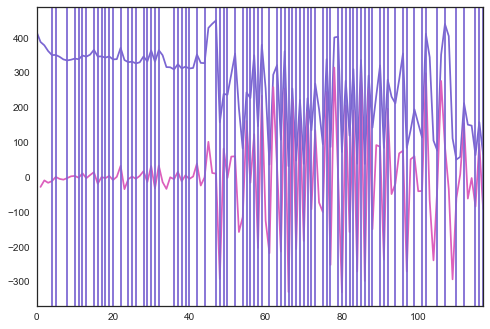

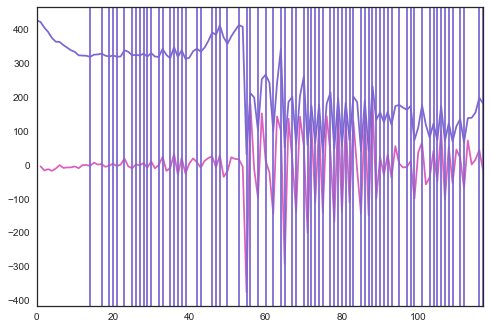

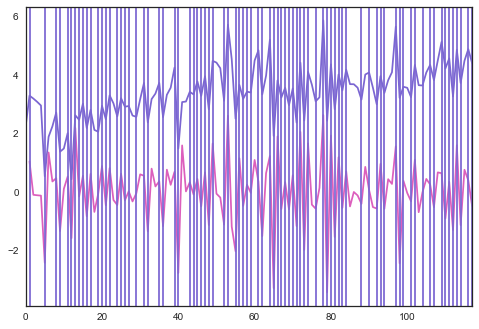

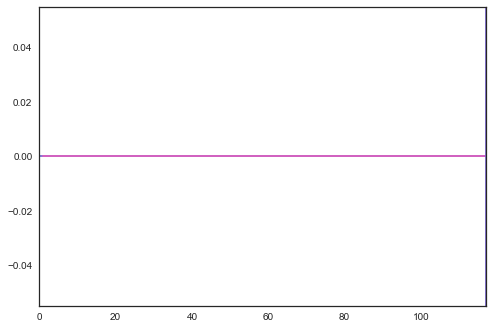

row  column Well strain  Measurement       Group        Time  OCR  \
Well                                                                           
A01  0       A       1  A01   Msgg            1  Background    1.313522  0.0   
     1       A       1  A01   Msgg            2  Background    7.759194  0.0   
     2       A       1  A01   Msgg            3  Background   14.212405  0.0   
     3       A       1  A01   Msgg            4  Background   20.656256  0.0   
     4       A       1  A01   Msgg            5  Background   27.115448  0.0   
     5       A       1  A01   Msgg            6  Background   33.568919  0.0   
     6       A       1  A01   Msgg            7  Background   40.022390  0.0   
     7       A       1  A01   Msgg            8  Background   46.470142  0.0   
     8       A       1  A01   Msgg            9  Background   52.930373  0.0   
     9       A       1  A01   Msgg           10  Background   59.380204  0.0   
     10      A       1  A01   Msgg           11  Background   65.841476  0.0   
     11      A       1  A01   Msgg           12  Background   72.295987  0.0   
     12      A       1  A01   Msgg           13  Background   78.759078  0.0   
     13      A       1  A01   Msgg           14  Background   85.218530  0.0   
     14      A       1  A01   Msgg           15  Background   91.684221  0.0   
     15      A       1  A01   Msgg           16  Background   98.142632  0.0   
     16      A       1  A01   Msgg           17  Background  104.604164  0.0   
     17      A       1  A01   Msgg           18  Background  111.069075  0.0   
     18      A       1  A01   Msgg           19  Background  117.548026  0.0   
     19      A       1  A01   Msgg           20  Background  124.023078  0.0   
     20      A       1  A01   Msgg           21  Background  130.496049  0.0   
     21      A       1  A01   Msgg           22  Background  136.959401  0.0   
     22      A       1  A01   Msgg           23  Background  143.431332  0.0   
     23      A       1  A01   Msgg           24  Background  149.900663  0.0   
     24      A       1  A01   Msgg           25  Background  156.370255  0.0   
     25      A       1  A01   Msgg           26  Background  162.830746  0.0   
     26      A       1  A01   Msgg           27  Background  169.317237  0.0   
     27      A       1  A01   Msgg           28  Background  175.790209  0.0   
     28      A       1  A01   Msgg           29  Background  182.262660  0.0   
     29      A       1  A01   Msgg           30  Background  188.730171  0.0   
...         ..     ...  ...    ...          ...         ...         ...  ...   
H12  11298   H      12  H12   MSgg           89  Background  571.795084  0.0   
     11299   H      12  H12   MSgg           90  Background  578.301596  0.0   
     11300   H      12  H12   MSgg           91  Background  584.834627  0.0   
     11301   H      12  H12   MSgg           92  Background  591.350759  0.0   
     11302   H      12  H12   MSgg           93  Background  597.883010  0.0   
     11303   H      12  H12   MSgg           94  Background  604.405902  0.0   
     11304   H      12  H12   MSgg           95  Background  610.919433  0.0   
     11305   H      12  H12   MSgg           96  Background  617.428804  0.0   
     11306   H      12  H12   MSgg           97  Background  623.973536  0.0   
     11307   H      12  H12   MSgg           98  Background  630.508907  0.0   
     11308   H      12  H12   MSgg           99  Background  637.044279  0.0   
     11309   H      12  H12   MSgg          100  Background  643.569510  0.0   
     11310   H      12  H12   MSgg          101  Background  650.106962  0.0   
     11311   H      12  H12   MSgg          102  Background  656.630373  0.0   
     11312   H      12  H12   MSgg          103  Background  663.162625  0.0   
     11313   H      12  H12   MSgg          104  Background  669.683956  0.0   
     11314   H      12  H12   MSgg          105  Background  676.200348  0.0   
     11315 

In [164]:
def find_peaks(well, test_plot=False):
    well = well.copy().reset_index(drop=True)
    
    # Get the first derivative (difference)
    difference = well.diff()

    # Get the sign of the first derivative
    asign = np.sign(difference)

    # Get each signchange in the first derivative
    signchange = pd.Series(((np.roll(asign, -1) - asign) != 0))

    # Set the initial condition to no change
    signchange.iloc[0] = 0

    
    if test_plot:
        # Plot the raw data
        well.plot()

        # Plot the derivative
        difference.plot()
        
        # Plot vertical lines for each sign change
        for x in signchange.index[signchange==1].tolist():
            plt.axvline(x)
        test_df=pd.DataFrame({'raw':well,'difference':difference,'sign of difference':asign, 'is signchange?':signchange})
        plt.show()
    return(signchange)

# Calculate the frequency of signchanges
# signchange.sum()/well.count()

def find_frequency(well, value, test_plot=False):
    well = well.sort_values('Time (hrs)')
    well.assign(Extrema=find_peaks(well[value], test_plot))
    return(well)

rate.groupby('Well').apply(find_frequency, value='OCR',test_plot=True)

RangeIndex(start=0, stop=118, step=1)


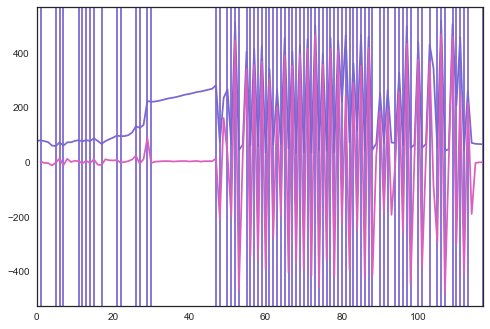

0      False
1       True
2      False
3      False
4      False
5       True
6       True
7       True
8      False
9      False
10     False
11      True
12      True
13      True
14      True
15      True
16     False
17      True
18     False
19     False
20     False
21      True
22      True
23     False
24     False
25     False
26      True
27      True
28     False
29      True
       ...  
88      True
89     False
90      True
91      True
92      True
93     False
94      True
95      True
96      True
97      True
98      True
99     False
100     True
101     True
102    False
103     True
104    False
105     True
106     True
107     True
108    False
109     True
110     True
111     True
112     True
113     True
114    False
115    False
116    False
117     True
Name: OCR, Length: 118, dtype: bool

In [163]:
def find_peaks(well, test_plot=False):
    well = well.copy().reset_index(drop=True)
    
    # Get the first derivative (difference)
    difference = well.diff()

    # Get the sign of the first derivative
    asign = np.sign(difference)

    # Get each signchange in the first derivative
    signchange = pd.Series(((np.roll(asign, -1) - asign) != 0))

    # Set the initial condition to no change
    signchange.iloc[0] = 0

    print(signchange.index)
    if test_plot:
        # Plot the raw data
        well.plot()

        # Plot the derivative
        difference.plot()

        
        # Plot vertical lines for each sign change
        for x in signchange.index[signchange==1].tolist():
            plt.axvline(x)
                plt.show()
        test_df=pd.DataFrame({'raw':well,'difference':difference,'sign of difference':asign, 'is signchange?':signchange})
    return(signchange)

test_well = rate.query('Well == "B02"')
test_well_OCR = test_well['OCR']

find_peaks(test_well_OCR, True)

In [50]:
rawtime = len(raw['Time (hrs)'])
ratetime = len(rate['Time (hrs)'])
print(rawtime/ratetime)

12.0


Column to plot:
Column to group replicates by:


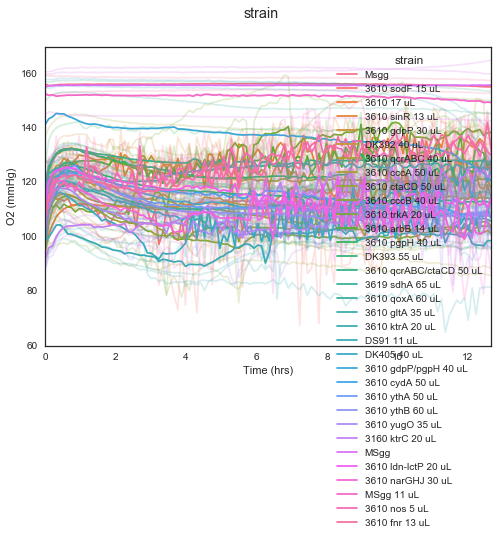

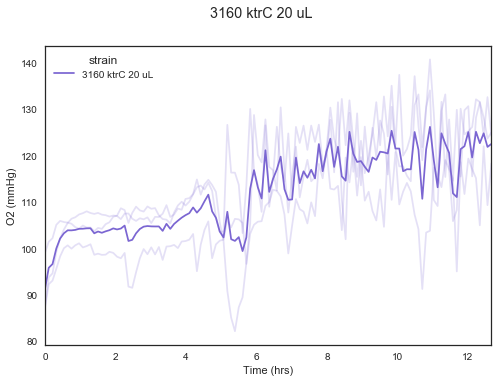

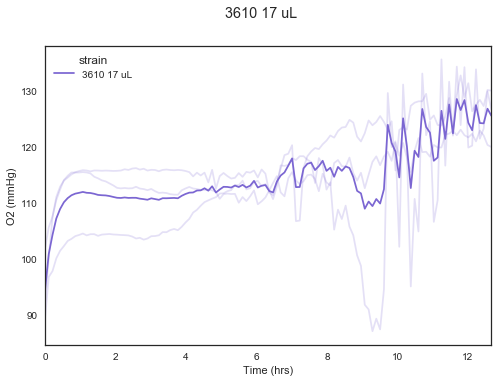

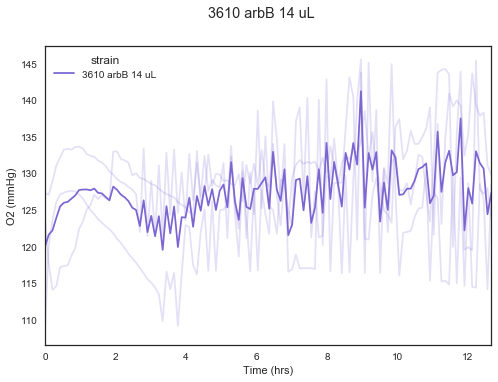

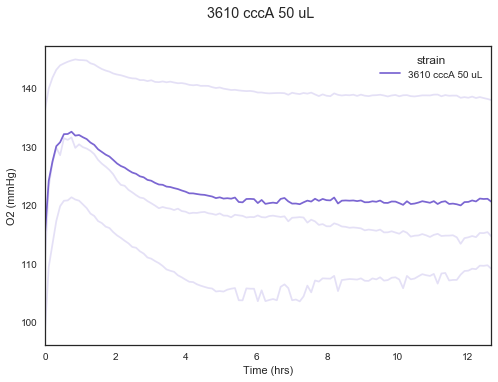

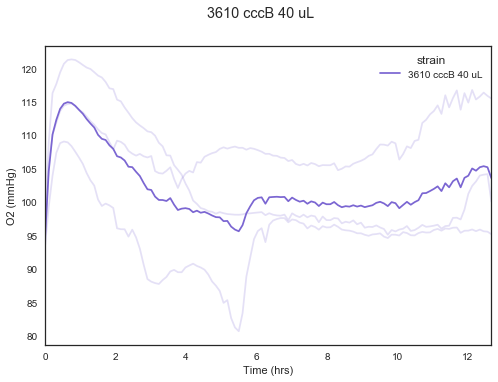

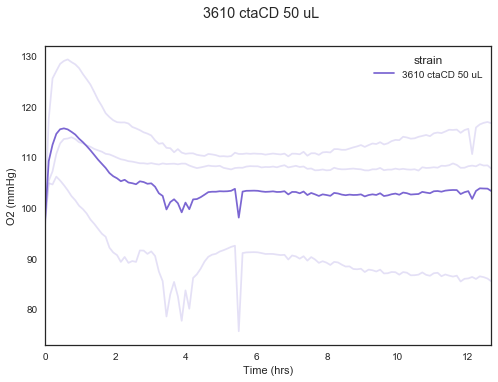

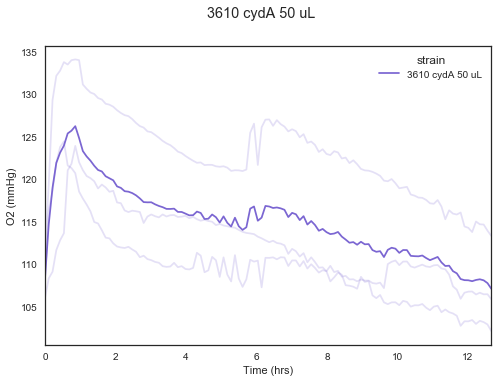

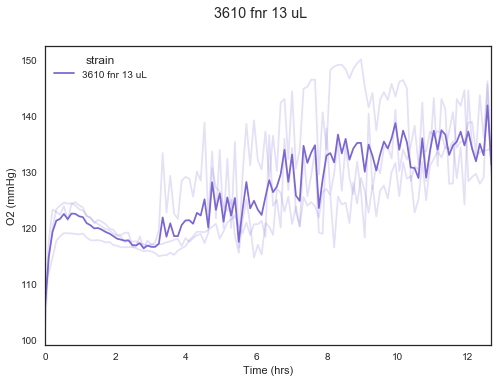

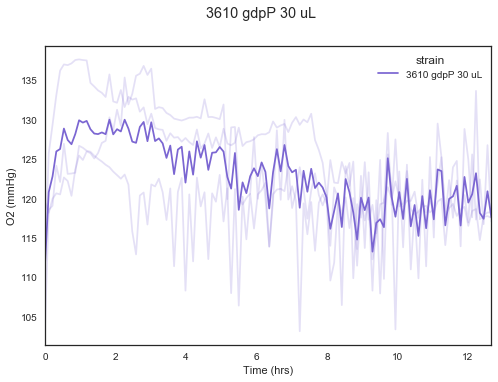

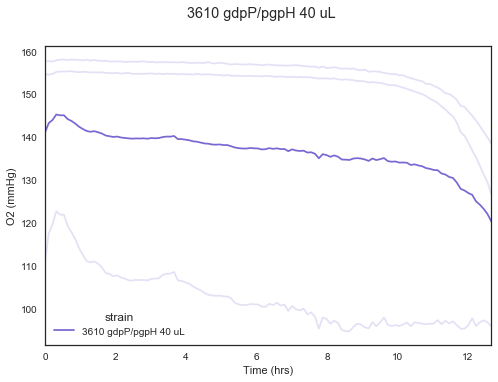

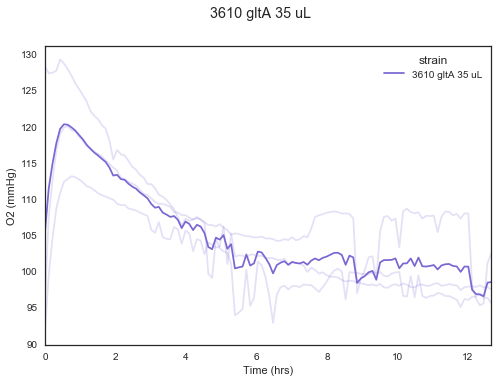

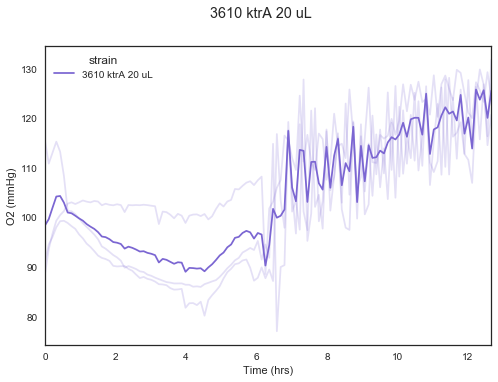

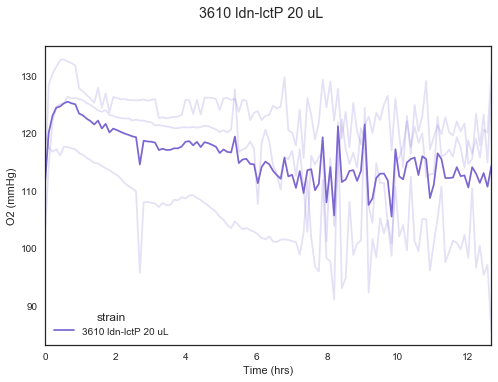

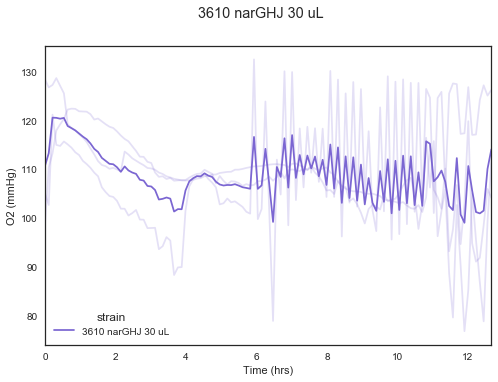

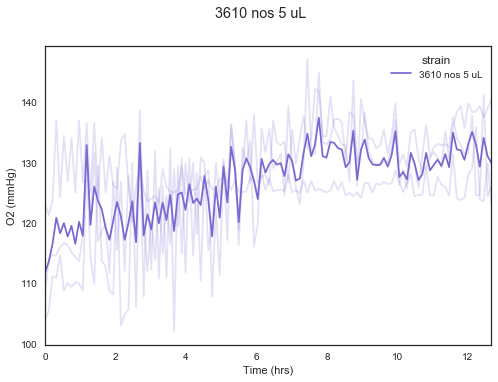

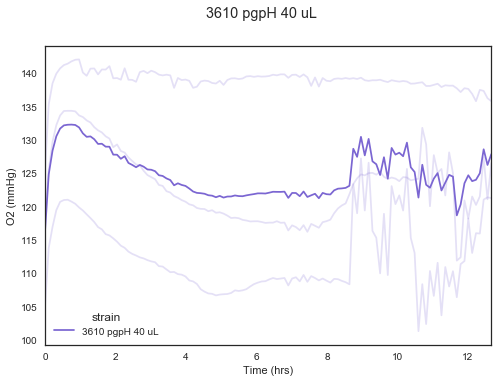

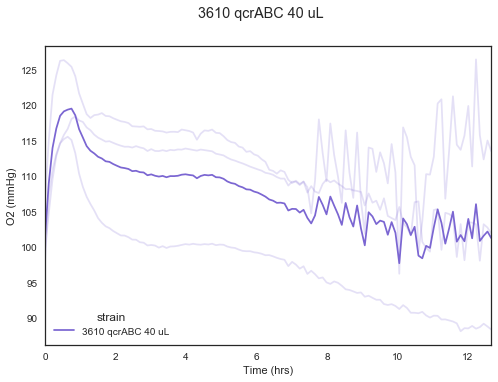

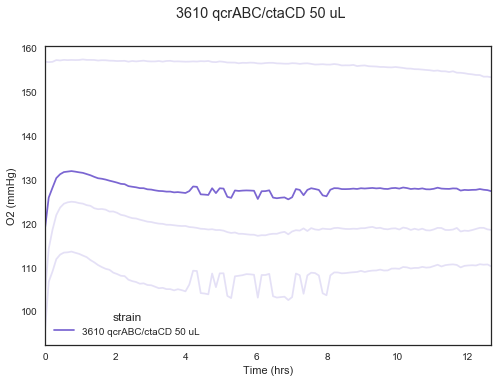

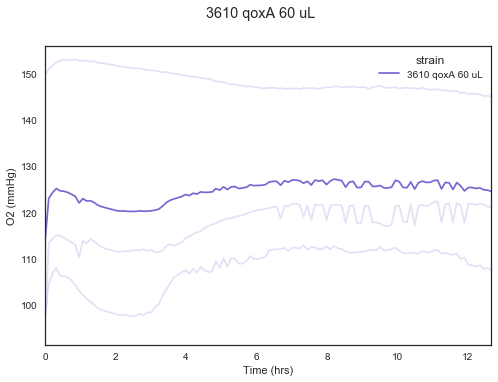

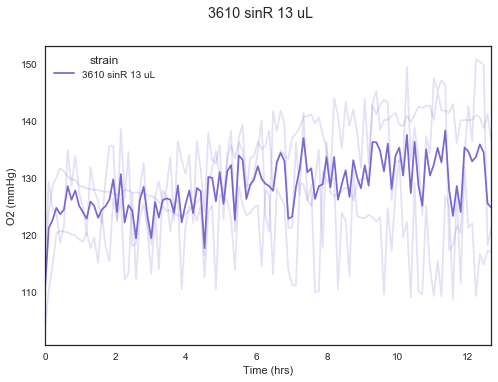

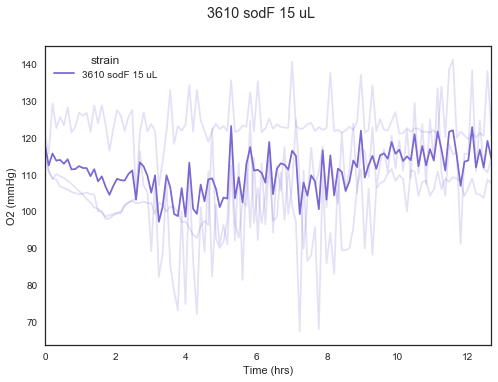

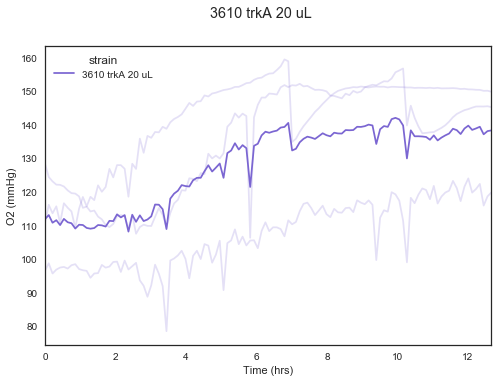

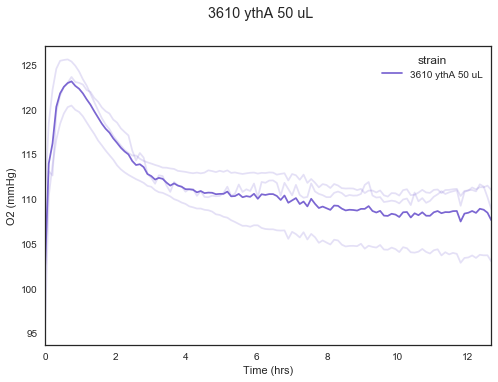

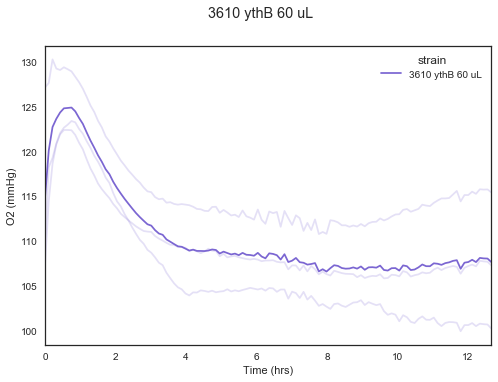

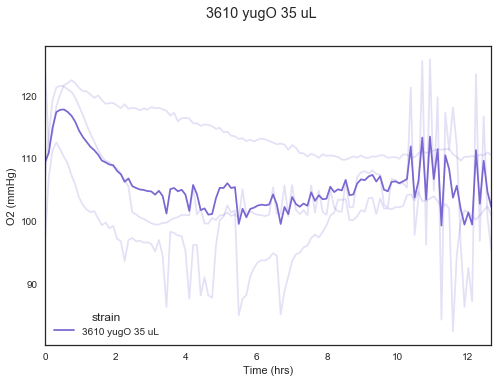

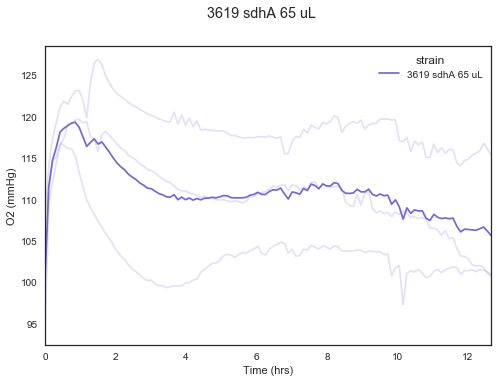

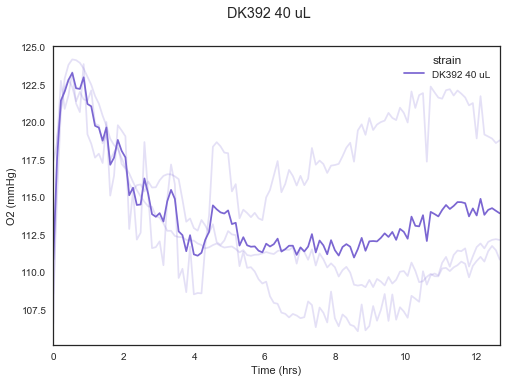

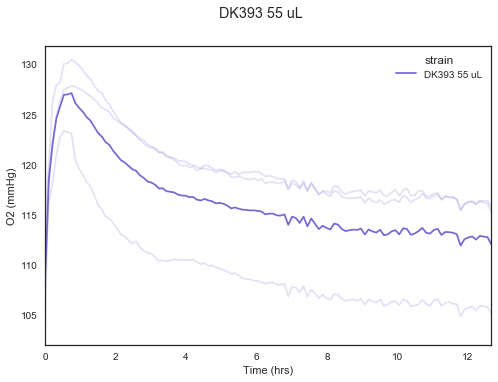

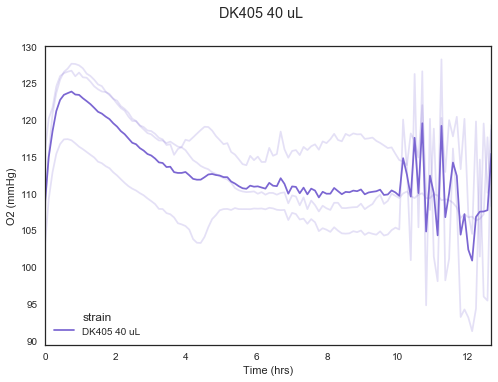

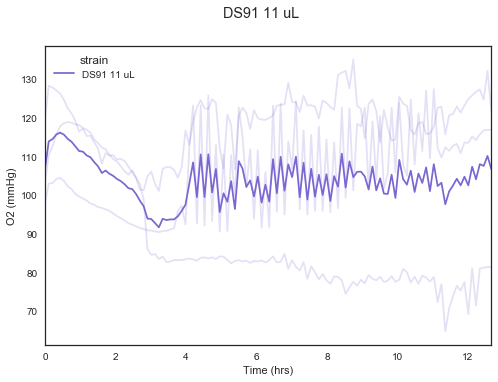

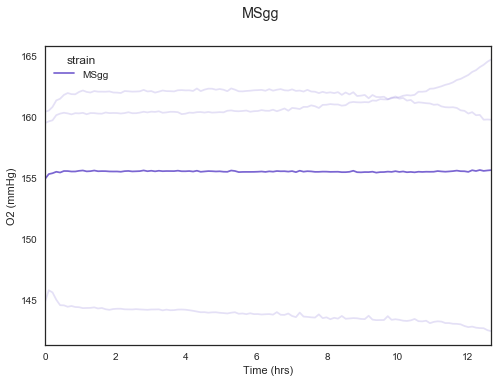

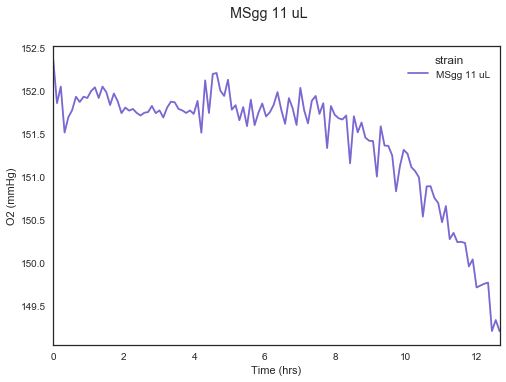

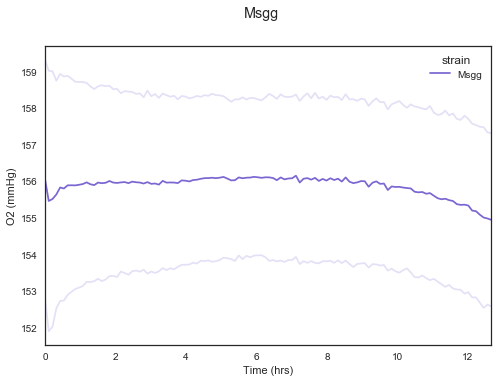

()

In [9]:
value = input('Column to plot:')
condition = input(prompt='Column to group replicates by:')


value = 'O2 (mmHg)'
condition = 'strain'
plot_variable(data=plate, condition=condition,value=value)

In [4]:
plate

row  column Well strain  Measurement  Tick       Group TimeStamp  \
0        A       1  A01   Msgg            1     0  Background  01:10:29   
1        A       1  A01   Msgg            1     1  Background  01:10:45   
2        A       1  A01   Msgg            1     2  Background  01:11:00   
3        A       1  A01   Msgg            1     3  Background  01:11:16   
4        A       1  A01   Msgg            1     4  Background  01:11:32   
5        A       1  A01   Msgg            1     5  Background  01:11:48   
6        A       1  A01   Msgg            1     6  Background  01:12:04   
7        A       1  A01   Msgg            1     7  Background  01:12:20   
8        A       1  A01   Msgg            1     8  Background  01:12:35   
9        A       1  A01   Msgg            1     9  Background  01:12:51   
10       A       1  A01   Msgg            1    10  Background  01:13:07   
11       A       1  A01   Msgg            1    11  Background  01:13:23   
12       A       1  A01   Msgg            2    12  Background  01:16:56   
13       A       1  A01   Msgg            2    13  Background  01:17:12   
14       A       1  A01   Msgg            2    14  Background  01:17:28   
15       A       1  A01   Msgg            2    15  Background  01:17:43   
16       A       1  A01   Msgg            2    16  Background  01:17:59   
17       A       1  A01   Msgg            2    17  Background  01:18:15   
18       A       1  A01   Msgg            2    18  Background  01:18:31   
19       A       1  A01   Msgg            2    19  Background  01:18:46   
20       A       1  A01   Msgg            2    20  Background  01:19:02   
21       A       1  A01   Msgg            2    21  Background  01:19:18   
22       A       1  A01   Msgg            2    22  Background  01:19:34   
23       A       1  A01   Msgg            2    23  Background  01:19:49   
24       A       1  A01   Msgg            3    24  Background  01:23:23   
25       A       1  A01   Msgg            3    25  Background  01:23:39   
26       A       1  A01   Msgg            3    26  Background  01:23:55   
27       A       1  A01   Msgg            3    27  Background  01:24:11   
28       A       1  A01   Msgg            3    28  Background  01:24:26   
29       A       1  A01   Msgg            3    29  Background  01:24:42   
...     ..     ...  ...    ...          ...   ...         ...       ...   
135906   H      12  H12   MSgg          116  1386  Background  13:38:47   
135907   H      12  H12   MSgg          116  1387  Background  13:39:02   
135908   H      12  H12   MSgg          116  1388  Background  13:39:18   
135909   H      12  H12   MSgg          116  1389  Background  13:39:34   
135910   H      12  H12   MSgg          116  1390  Background  13:39:50   
135911   H      12  H12   MSgg          116  1391  Background  13:40:05   
135912   H      12  H12   MSgg          117  1392  Background  13:43:44   
135913   H      12  H12   MSgg          117  1393  Background  13:44:00   
135914   H      12  H12   MSgg          117  1394  Background  13:44:16   
135915   H      12  H12   MSgg          117  1395  Background  13:44:32   
135916   H      12  H12   MSgg          117  1396  Background  13:44:47   
135917   H      12  H12   MSgg          117  1397  Background  13:45:03   
135918   H      12  H12   MSgg          117  1398  Background  13:45:19   
135919   H      12  H12   MSgg          117  1399  Background  13:45:35   
135920   H      12  H12   MSgg          117  1400  Background  13:45:50   
135921   H      12  H12   MSgg          117  1401  Background  13:46:06   
135922   H      12  H12   MSgg          117  1402  Background  13:46:22   
135923   H      12  H12   MSgg          117  1403  Background  13:46:38   
135924   H      12  H12   MSgg          118  1404  Background  13:50:17   
135925   H      12  H12   MSgg          118  1405  Background  13:50:32   
135926   H      12  H12   MSgg          118  1406  Background  13:50:48   
135927   H      12  H12   MSgg  

plate.query('Well == "A01"')['O2 (mmHg)'][0:36].plot()
plt.axvline(12)